<font size = 5>ЦЕЛЬ

<font size = 3>Подготовить основу рекомендательной системы.

<font size = 5>ЗАДАЧИ

<font size = 3>Итак, продакт ожидает получить от вас рекомендательную систему, благодаря которой можно будет предлагать клиентам интересные им курсы и тем самым повышать средний чек.

Вы решаете, что изначальным воплощением этой системы может стать таблица, в которой курсам будет соответствовать по две рекомендации.

Кроме того, вы планируете вместе с отчётом (таблицей рекомендаций) скинуть продакту ещё и все написанные в процессе скрипты, чтобы было меньше вопросов по решению :) Ну, и раз в код будут смотреть не только ваши глаза, вы считаете необходимым снабдить его комментариями, которые бы разъясняли, что где и почему вы делаете.

Также вы понимаете, что перед внедрением фичи коллеги решат провести A/B-тест и вас скорее всего привлекут к анализу результатов.

Перспективы ясны, можно переходить к формализации задач.

<font size = 5>КОНКРЕТНЫЕ ШАГИ (ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ)

<font size = 3>Обдумав план предстоящей работы, вы понимаете, что действовать нужно по привычной схеме:

1. Познакомиться с датасетом, подготовить и проанализировать данные с помощью SQL.
2. Обработать данные средствами Python.
3. Составить итоговую таблицу с рекомендациями, снабдив её необходимыми комментариями, и представить отчёт продакт-менеджеру.
4. Проанализировать результаты A/B-теста, проведённого после внедрения фичи, и сделать вывод.

<font size = 5>Займёмся первым шагом

In [ ]:
#импортируем необходимые библиотеки
import pandas as pd
import psycopg2
import psycopg2.extras 
import numpy as np
import itertools 
from collections import Counter

<font size = 5>Определим кол-во клиентов, купивших курсы

In [ ]:
#пишем SQL-запрос для определения кол-ва клиентов, купивших курсов
def getCountClients():
    query = '''select 
                          COUNT(DISTINCT user_id) count_clients
                       from final.carts 
                          join final.cart_items on final.carts.id = final.cart_items.cart_id
                       where
                       final.cart_items.resource_type = 'Course' and final.carts.state = 'successful'
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

count_clients = pd.DataFrame(getCountClients())
#выводим полученный результат
count_clients

,count_clients
0,49006


Получаем 49006 клиентов, которые купили курсы

<font size = 5>Посчитаем количество различных курсов

In [ ]:
#пишем SQL-запрос для определения кол-ва различных курсов
def getCountCourses():
    query = '''select 
                         COUNT(DISTINCT resource_id) count_courses
                       from final.cart_items 
                       where final.cart_items.resource_type = 'Course'
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

count_courses = pd.DataFrame(getCountCourses())
count_courses

,count_courses
0,127






Получилось 127 различных курсов

<font size = 5>Найдем среднее число купленных курсов на одного клиента


In [ ]:
#пишем SQL-запрос для определения среднего числа купленных курсов на одного клиента
def getAvgCountCourses():
    query = '''--создаём CTE для расчёта кол-ва купленных курсов у каждого клиента
                           with courses as
                           (select distinct fc.user_id, count(fci.resource_id) as course_count
                           from final.carts fc
                           join final.cart_items fci on fc.id=fci.cart_id
                           where fc.state = 'successful' and fci.resource_type='Course'
                           group by 1)

--среднее число купленных курсов на одного клиента

                          select round(avg(course_count),2) avg_count_courses
                          from courses
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

avg_count_courses = pd.DataFrame(getAvgCountCourses())
avg_count_courses

,avg_count_courses
0,1.44





Вышло 1.44 курсов в среднем покупает каждый клиент

<font size = 5>Посчитаем кол-во клиентов, которые купили больше одного курса

In [ ]:
#пишем SQL-запрос для определения кол-ва клиентов, которые купили больше одного курса
def getCountClients2():
    query = '''
--создаём CTE с пользователями и их купленными курсами

                         with users_courses as(
                         select distinct fc.user_id, fci.resource_id
                         from final.carts fc
                         join final.cart_items fci on fc.id=fci.cart_id
                         where fc.state = 'successful' and fci.resource_type='Course'
                         order by fc.user_id), courses as(

--создаём CTE с пользователями и количеством купленных курсов

                         select user_id, count(resource_id) as course_count
                         from users_courses
                         group by 1)

--считаем пользователей, которые купили больше 1 курса

                         select count(user_id) count_clients_2
                         from courses
                         where course_count>1
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

count_clients_2 = pd.DataFrame(getCountClients2())
count_clients_2

,count_clients_2
0,12656






Получилось 12656 пользователей, которые купили больше 1 курса

<font size = 5>По этому SQL-запросу я создал таблицу, в которой прописан ID клиента и ID купленного курса. С этой таблицей я стал дальше работать



In [ ]:
#пишем SQL-запрос, где оставляем id клиента и id купленного им курса
def getUsersAndResource():
    query = '''select
                         distinct fc.user_id, fci.resource_id
                         from final.carts fc
                         join final.cart_items fci on fc.id=fci.cart_id
                         where fc.state = 'successful' and fci.resource_type='Course'
                         order by fc.user_id
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

df = pd.DataFrame(getUsersAndResource())
df.head()

,user_id,resource_id
0,51,516
1,51,1099
2,974,356
3,2233,1125
4,2581,1187


In [ ]:
#удаляем дублирующиеся строки в случае, когда клиент несколько раз покупал один и тот же курс
df.drop_duplicates(subset=['user_id', 'resource_id'], keep='first')


,user_id,resource_id
0,51,516
1,51,1099
2,974,356
3,2233,1125
4,2581,1187
...,...,...
70419,2190509,742
70420,2190575,757
70421,2190589,1125
70422,2190991,489


In [ ]:
#найдём 2 самых популярных курса, которые пригодятся для таблицы рекомендаций в случае, если для курса не нашлись рекомендации
group_df_2 = df.groupby('resource_id').count()
group_df_2.reset_index(level=0, inplace=True) 
group_df_2 = group_df_2[['resource_id','user_id']].rename(columns={'user_id':'count_purchase'})
group_df_2.sort_values(by=['count_purchase'], inplace=True, ascending=False)
first_resource_by_popular = group_df_2['resource_id'][0:1].sum()
second_resource_by_popular = group_df_2['resource_id'][1:2].sum()


In [ ]:
#группируем датафрейм по user_id для того, чтобы видеть список курсов по каждому пользователю
group_df = df.groupby('user_id')['resource_id'].apply(lambda x:list(np.unique(x))).reset_index()
group_df.head()

,user_id,resource_id
0,51,"[516, 1099]"
1,974,[356]
2,2233,[1125]
3,2581,[1187]
4,3480,[745]


In [ ]:
#разбиваем список курсов на пары
list_courses = list()
for resource in group_df['resource_id']:
  for pair in itertools.combinations(resource,2):
    list_courses.append(pair)    

In [ ]:

list_courses_set = set(list_courses)
#считаем кол-во различных пар курсов встречаются вместе в покупках клиентов
len(list_courses_set)


3989

In [ ]:
#группируем список для и находим самую популярную пару
c = Counter(list_courses)

print('Самая популярная пара курсов: ',c.most_common(1))

Самая популярная пара курсов:  [((551, 566), 797)]


In [ ]:
#сортируем словарь по номерам курсов в паре
sorted_pairs = {k: v for k, v in sorted(c.items(), key=lambda item: item[0], reverse=False)}
sorted_pairs

{(356, 357): 100,
 (356, 360): 1,
 (356, 361): 17,
 (356, 366): 15,
 (356, 367): 12,
 (356, 368): 1,
 (356, 489): 26,
 (356, 490): 13,
 (356, 502): 17,
 (356, 503): 1,
 (356, 508): 1,
 (356, 509): 5,
 (356, 513): 1,
 (356, 514): 35,
 (356, 515): 21,
 (356, 516): 16,
 (356, 517): 3,
 (356, 519): 14,
 (356, 523): 24,
 (356, 551): 48,
 (356, 552): 7,
 (356, 553): 5,
 (356, 564): 3,
 (356, 566): 21,
 (356, 568): 6,
 (356, 569): 2,
 (356, 570): 1,
 (356, 571): 103,
 (356, 659): 4,
 (356, 671): 2,
 (356, 672): 4,
 (356, 679): 8,
 (356, 742): 1,
 (356, 743): 1,
 (356, 745): 8,
 (356, 749): 1,
 (356, 750): 3,
 (356, 753): 3,
 (356, 756): 5,
 (356, 757): 1,
 (356, 764): 8,
 (356, 765): 35,
 (356, 776): 2,
 (356, 777): 4,
 (356, 791): 1,
 (356, 794): 10,
 (356, 800): 3,
 (356, 803): 1,
 (356, 809): 2,
 (356, 829): 5,
 (356, 835): 1,
 (356, 840): 1,
 (356, 862): 3,
 (356, 863): 1,
 (356, 866): 1,
 (356, 907): 1,
 (356, 908): 3,
 (356, 909): 3,
 (356, 912): 34,
 (356, 1099): 3,
 (356, 1100): 5,
 (

In [ ]:
#создаём список уникальных курсов
courses = df['resource_id'].unique()

In [ ]:
#создаём функцию, которая к каждому курсу соотносит пару курсов, в которой присутствует данный курс
def recommend(course):
  course_list = []
  for i in sorted_pairs.keys():
    if i[0] == course:
      course_list.append((i, sorted_pairs[i]))
  sourted_cource_list = sorted(course_list, key=lambda x: x[1], reverse=True)
  return sourted_cource_list[:2]    

In [ ]:
#создаём таблицу рекомендаций по каждому купленному курсу
recomend_df = pd.DataFrame(columns = ['Recommendation 1', 'Recommendation 2'])
for i in courses:
#применяем функция, если есть 2 рекомендации  
  if len (recommend(i)) == 2: 
    recomend_df.loc[i] = [recommend(i)[0][0][1], recommend(i)[1][0][1]]
#применяем функция, если есть 1 рекомендации, а второй рекоммендацией будет самый популярный курс
  elif len (recommend(i)) == 1:   
    recomend_df.loc[i] = [recommend(i)[0][0][1], first_resource_by_popular]
  else:
#если ничего не находит, то рекомендуем 2 самых популярных курса по кол-ву покупок
    recomend_df.loc[i] = [first_resource_by_popular, second_resource_by_popular]  

In [ ]:
#полученная таблица рекомендаций
recomend_df


,Recommendation 1,Recommendation 2
516,745,553
1099,1139,1187
356,571,357
1125,1186,1144
1187,1188,551
...,...,...
1182,1187,551
902,551,566
837,840,1161
1200,551,566


Похожую логику такой рекомендованной таблицы я смог реализовать в Power Query и Power BI. Немного пропишу шаги моих действий:

1. Я взял ту же таблицу, что и использовал в Python, где 2 столбца: id клиента и id купленного им курса, и загрузил её в Power Query и, с помощью некоторых махинаций, я получил 2 таблица: одна просто была как справочником уникальных ID курсов, встречавшихся в паре, и вторая, где были прописаны все возможные получившиеся пары по всем клиентам, купившим минимум 2 курса. По факту, этот тоже list_courses, который получался через код в Python. 

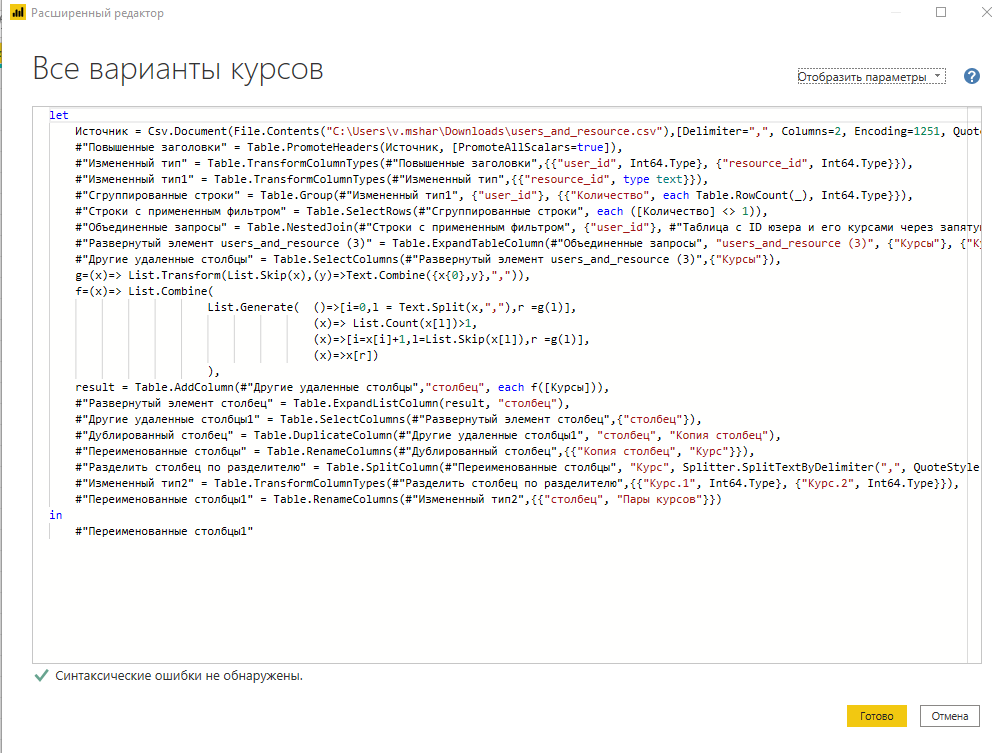


По такому запросу получилась таблица в 3 столбца, показанная ниже 

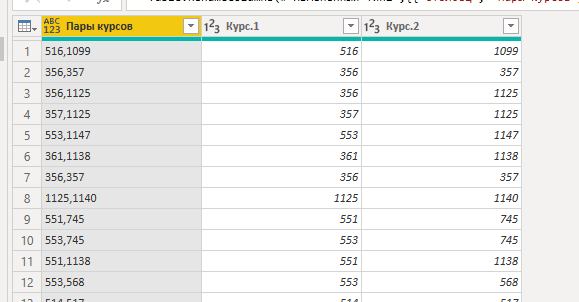

2. При помощи одной активной и другой неактивной связей получил возможность начать считать кол-во встречаний по каждой из пар. Связи показаны ниже 
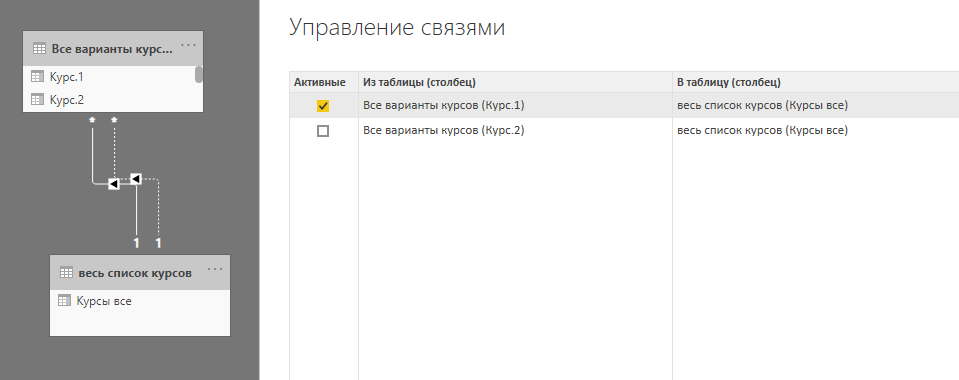


3. После чего, мерой считаем кол-во встречаний по первому курсу из пары, а затем, с активацией второй связи, кол-во по второму курсу ну и после их складываем.

В итоге, получилось создать матрицу, которая, выбрав нужный ID курса, отображает две наиболее часто встречаювшиеся пары, где присутвует данный курс, которые можно использовать для рекомендаций.

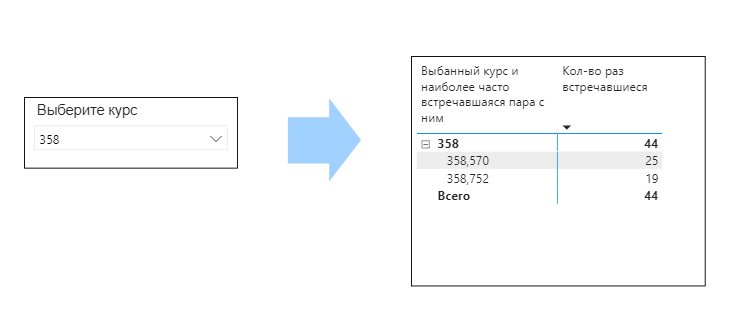

<font size = 5>Вывод:
<font size = 3>Небольшим преимуществом варианта с использованием Power Query и Power BI в том, что тут отсутвуют курсы, к которым не подобрались рекомендации.

<font size = 4>Последним шагом было:

<font size = 5>Проанализировать результаты A/B-теста, проведённого после внедрения фичи, и сделать вывод

По данным, которые мы собрали, по использованию новой фичи с рекомендуемыми курсами.
Сначала выяснили, что до реализации рекомендаций средняя конверсия в покупку второго курса была 3,2%, а преодполагаем, что после рекомендаций конверсия станет 4%. И для определения минимального размера выборки для проведения теста при уровне достоверности 95% и статистической мощности 80%, мы воспользовались онлайн-[калькулятором Эвана-Миллера](https://www.evanmiller.org/ab-testing/sample-size.html). Он показал, что необходимо, чтобы в выборке было больше 7866 значений.


Спустя 3 недели численное выражение полученных результатов таково:

В контрольной группе оказалось 8732 клиента, оформивших заказ, из них 293 купили больше одного курса.

В тестовой — 8847 клиентов, из них 347 купили больше одного курса.



С помощью ещё одного [онлайн-калькулятора](https://abtestguide.com/calc/) расчитали p-value, который получился 0.002. Из чего можно сделать вывод, что вариант с рекомендациями показал статистически значимо лучший результат, нужно реализовывать его для всех клиентов.